***Guneykan Ozkaya***

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simulate-several-paths-of-the-stock-price." data-toc-modified-id="Simulate-several-paths-of-the-stock-price.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulate several paths of the stock price.</a></span></li><li><span><a href="#Value-of-the-call-option-as-a-function-of-time-using-one-of-the-paths" data-toc-modified-id="Value-of-the-call-option-as-a-function-of-time-using-one-of-the-paths-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Value of the call option as a function of time using one of the paths</a></span></li><li><span><a href="#Value-of-the-hedging-portfolio-assuming-that-it-has-been-rebalanced-daily.-And-the-hedging-error." data-toc-modified-id="Value-of-the-hedging-portfolio-assuming-that-it-has-been-rebalanced-daily.-And-the-hedging-error.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Value of the hedging portfolio assuming that it has been rebalanced daily. And the hedging error.</a></span></li><li><span><a href="#Recovering-Implied-Volatility-with-Newton's-Method" data-toc-modified-id="Recovering-Implied-Volatility-with-Newton's-Method-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Recovering Implied Volatility with Newton's Method</a></span></li></ul></div>

In [1132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Simulate several paths of the stock price.

In [409]:
vol_1 = 0.17
vol_1_3 = 0.15
vol_3_5 = 0.13
vol_5 = 0.12
T = 1/2
n = 1000
s_0 = 100
r = 0.05
k = 100

In [410]:
def calculate_spot(prev, sigma, r, step, random):
    
    return(prev + (sigma*prev*random) + (r*prev*step))

def sim_spot(s0, r, steps, maturity, vol_1, vol_1_3, vol_3_5, vol_5):
    delta_t = T/steps
    time = np.round(np.arange(0, maturity+delta_t, delta_t), 4)
    prices = [s0]
    normal_dist = np.random.normal(0, np.sqrt(delta_t), 10000)
    for a in range(steps):
        if time[a+1] < np.round(1/12, 3):
            prices.append(calculate_spot(prices[-1], vol_1, r, delta_t, normal_dist[a]))
        elif np.round(1/12, 3) <= time[a+1] < np.round(3/12, 3):
            prices.append(calculate_spot(prices[-1], vol_1_3, r, delta_t, normal_dist[a]))
        elif np.round(3/12, 3) <= time[a+1] < np.round(5/12, 3):
            prices.append(calculate_spot(prices[-1], vol_3_5, r, delta_t, normal_dist[a]))
        elif time[a+1] >= np.round(5/12, 3):
            prices.append(calculate_spot(prices[-1], vol_5, r, delta_t, normal_dist[a]))
    
    return(prices)

In [411]:
sims = pd.DataFrame()
for a in range(5):
    sims[a] = sim_spot(s_0, r, n, T, vol_1, vol_1_3, vol_3_5, vol_5)

sims.columns = ["Sim_1", "Sim_2", "Sim_3", "Sim_4", "Sim_5"]
sims.index = np.round(np.arange(0, 0.5+(0.5/1000), 0.5/1000), 4)

[Text(0, 0.5, 'Prices'), Text(0.5, 0, 'Steps'), Text(0.5, 1.0, 'Simulations')]

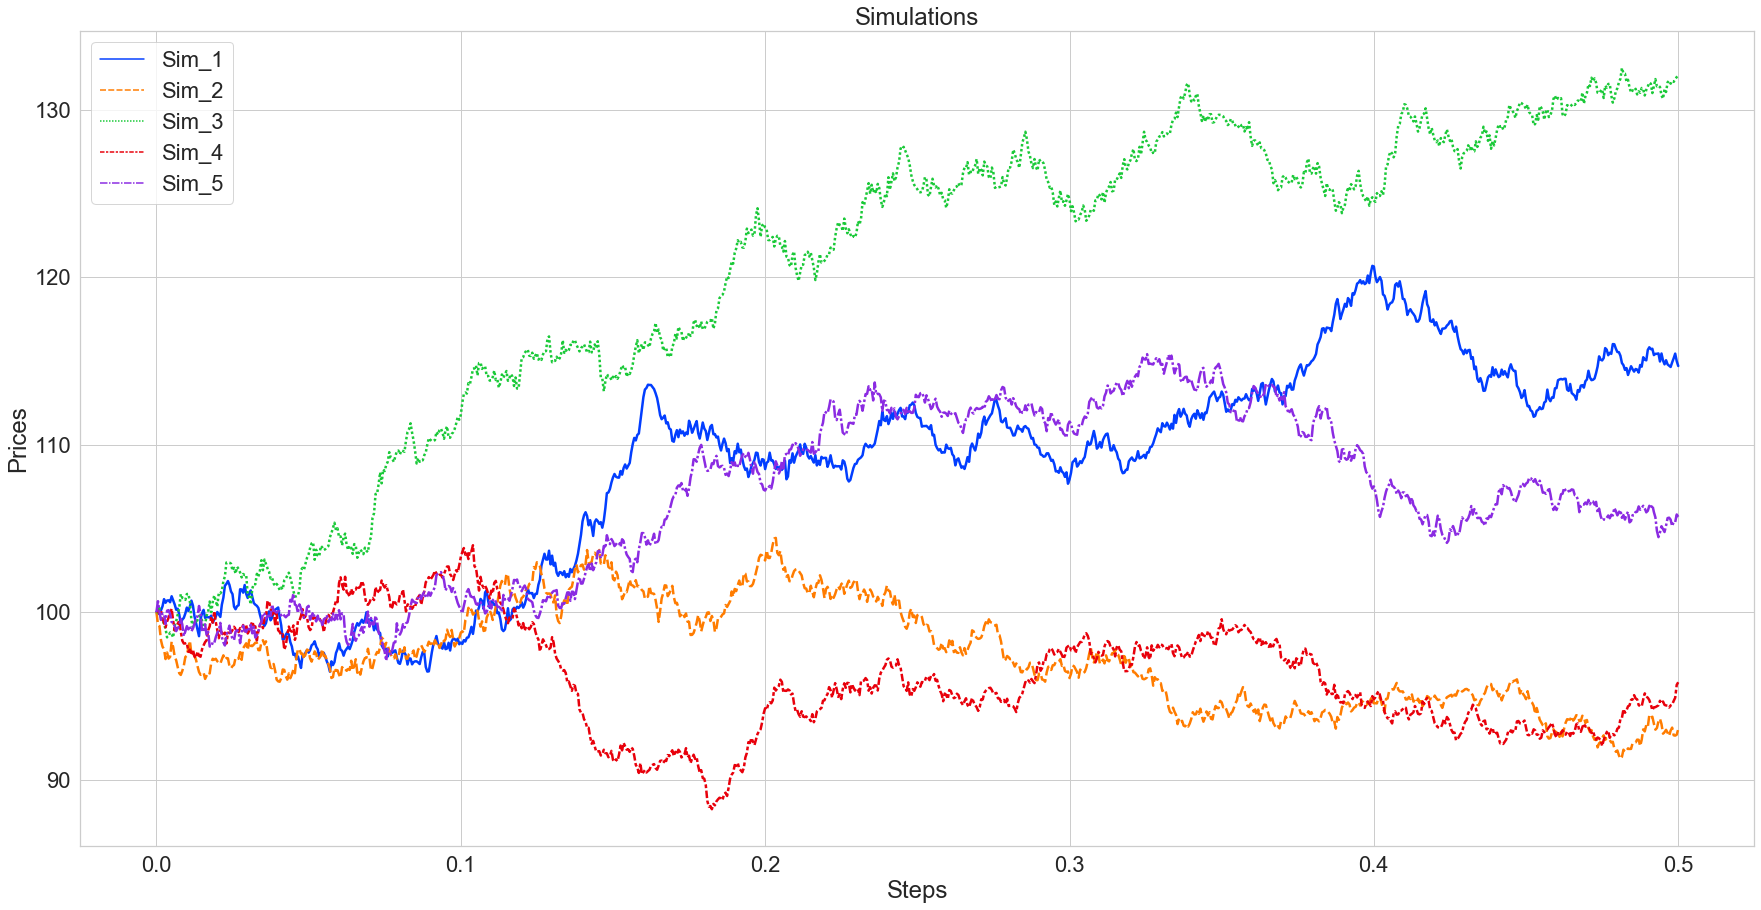

In [1182]:
sns.set(style="whitegrid", font_scale=2)
plt.figure(figsize=(30,15))
ax = sns.lineplot(data=sims, palette="bright", linewidth=2.5)
ax.set(xlabel='Steps', ylabel='Prices', title="Simulations")


    

In [413]:
import scipy.integrate as integrate
def variance(x): return 0.17**2 if x < 1/12 else (0.15**2 if 1/12 <= x < 3 /
                                         12 else (0.13**2 if 3/12 <= x < 5/12 else (0.12**2 if 5/12 <= x else None)))

def d1(s, k, r, t, T):
    if T != t:
        nomin = np.log(s/k) + (r + 0.5*(1/(T-t))*integrate.quad(variance, t, T, limit=100)[0])*(T-t)
        denom = np.sqrt((1/(T-t))*integrate.quad(variance, t, T, limit=100)[0])*np.sqrt((T-t))
        return(nomin/denom)
    else:
        None
        
        
def d2(s, k, r, t, T):
    if T != t:
        nomin = np.log(s/k) + (r - 0.5*(1/(T-t))*integrate.quad(variance, t, T, limit=100)[0])*(T-t)
        denom = np.sqrt((1/(T-t))*integrate.quad(variance, t, T, limit=100)[0])*np.sqrt((T-t))
        return(nomin/denom)
    else:
        None
        
def call(d1, d2, k, r, T, t, s):
    return(s*scipy.stats.norm.cdf(d1) - k*np.exp(-r*(T-t))*scipy.stats.norm.cdf(d2))

In [478]:
call_prices = []
deltas = []
for (a,b) in zip(sims["Sim_1"], sims.index):
    if b!=T:
        d1_ = d1(a, k, r, b, T)
        d2_ = d2(a, k, r, b, T)
        call_prices.append(call(d1_, d2_, k, r, T, b, a))
        deltas.append(scipy.stats.norm.cdf(d1_))
    else:
        call_prices.append(max(a-k, 0))
        deltas.append("nope")
    
    

In [479]:
opt_price = pd.DataFrame(call_prices, sims.index)
opt_price = opt_price.rename(columns={0:"Sim_1_Call"})

In [480]:
opt_price = pd.concat([opt_price, sims["Sim_1"]], axis=1)

In [481]:
min_max = MinMaxScaler(feature_range=(min(call_prices), max(call_prices)))
opt_price["Sim_1_scaled"] = min_max.fit_transform(opt_price["Sim_1"].values.reshape(-1,1))
opt_price["deltas"] = deltas
opt_price.index = pd.date_range(start='01/01/2018', end='06/01/2018', periods=1001)

# Value of the call option as a function of time using one of the paths

[Text(0, 0.5, 'Call Prices'),
 Text(0.5, 0, 'Steps'),
 Text(0.5, 1.0, 'Simulation 1')]

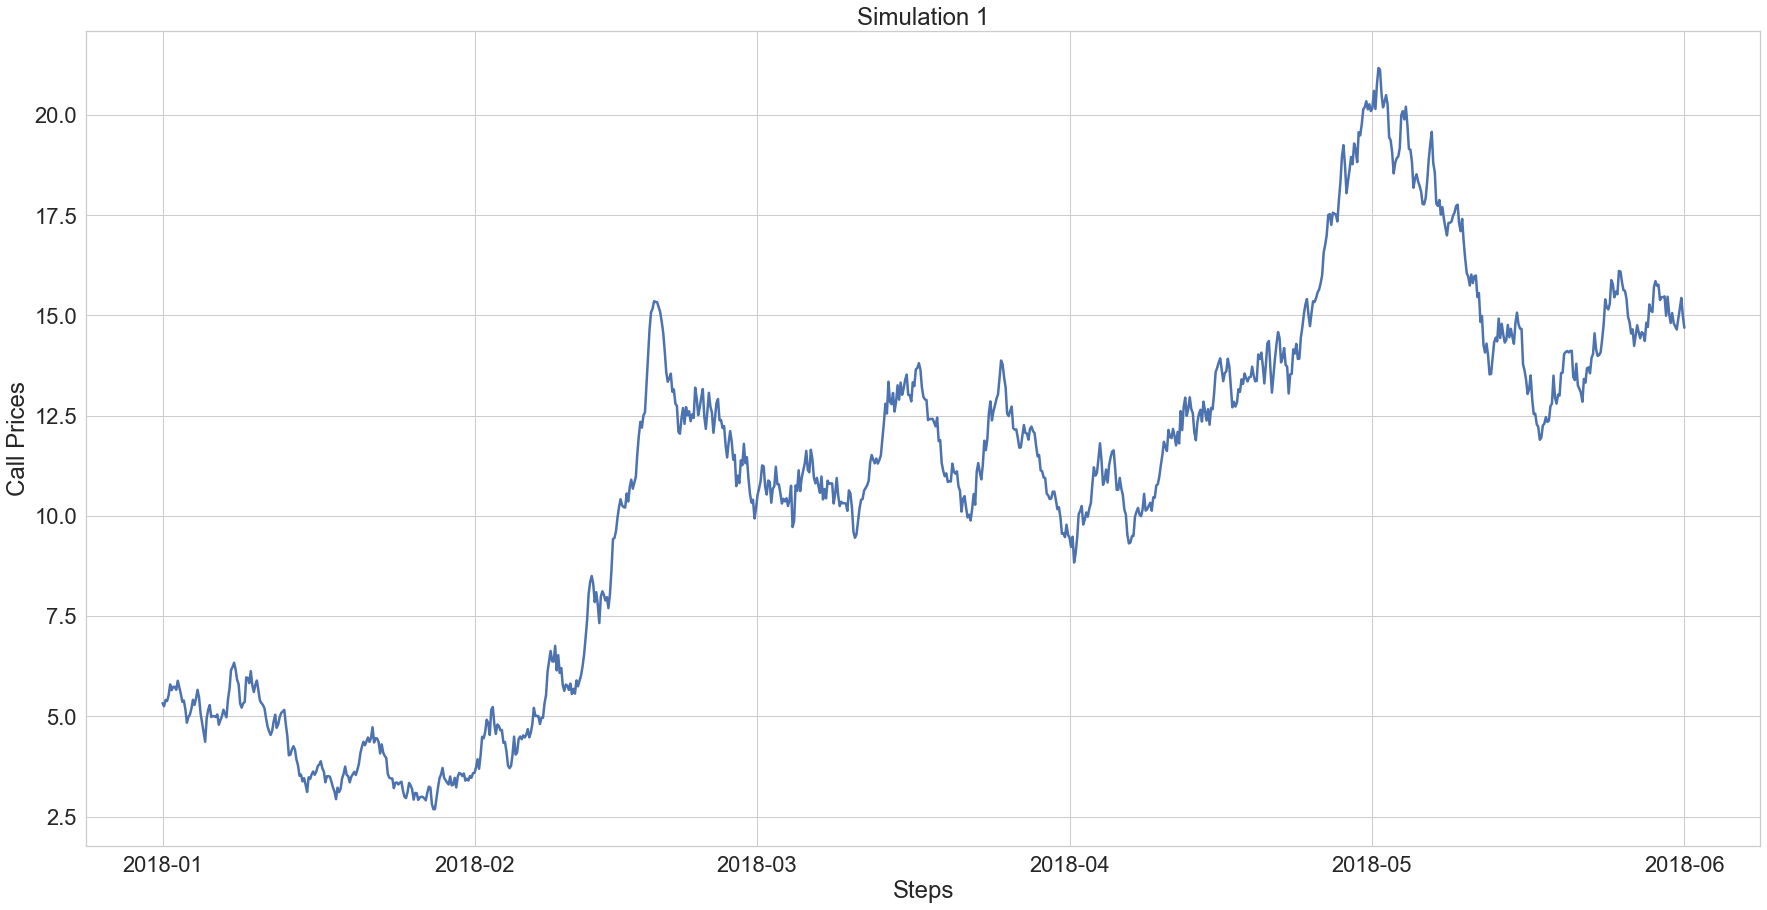

In [1183]:
sns.set(style="whitegrid", font_scale=2)
plt.figure(figsize=(30,15))
ax = sns.lineplot(data=opt_price["Sim_1_Call"], palette="bright", linewidth=2.5)
ax.set(xlabel='Steps', ylabel='Call Prices', title="Simulation 1")

In [885]:
def hedger(data, return_cont_hedge=True):
    hedge_port_daily = [data["Sim_1_Call"].iloc[0]]
    hedge_port_cont = [data["Sim_1_Call"].iloc[0]]
    daily_delta = data["deltas"].iloc[0]
    delta_daily = [daily_delta]
    yesterday = data.index[0].day
    for a in range(len(opt_price)):
        if data.index[a] != data.index[-1]:
            value = hedge_port_cont[-1]*np.exp(r*0.5/1000) + data["deltas"].iloc[a]*(data["Sim_1"].iloc[a+1] -
                                                                                     data["Sim_1"].iloc[a] *
                                                                                     np.exp(r*0.5/1000))
            hedge_port_cont.append(value)
            if data.index[a].day != yesterday:
                value = hedge_port_daily[-1]*np.exp(r*0.5/1000) + daily_delta*(data["Sim_1"].iloc[a+1] -
                                                                               data["Sim_1"].iloc[a] *
                                                                               np.exp(r*0.5/1000))
                daily_delta = data["deltas"].iloc[a+1]
                hedge_port_daily.append(value)
                delta_daily.append(data["deltas"].iloc[a+1])
                yesterday = data.index[a+1].day
            else:
                value = hedge_port_daily[-1]*np.exp(r*0.5/1000) + daily_delta*(data["Sim_1"].iloc[a+1] -
                                                                               data["Sim_1"].iloc[a] *
                                                                               np.exp(r*0.5/1000))
                hedge_port_daily.append(value)
                delta_daily.append(delta_daily[-1])
        else:
            pass
    if return_cont_hedge == True:
        return(hedge_port_cont, hedge_port_daily)
    else:
        return(hedge_port_daily)

In [886]:
hedge_port_cont, hedge_port_daily = hedger(opt_price, return_cont_hedge=True)

In [921]:
opt_price["port_cont"] = hedge_port_cont
opt_price["port_daily"] = hedge_port_daily
opt_price["delta_daily"] = delta_daily
opt_price["deltas"]["2018-06"] = 1
opt_price["deltas"] = opt_price.deltas.astype(float)
opt_price["error_cont"] = opt_price["Sim_1_Call"] - opt_price["port_cont"]
opt_price["error_daily"] = opt_price["Sim_1_Call"] - opt_price["port_daily"]
opt_price["hedge_ratio_cont"] = opt_price["port_cont"]/opt_price["Sim_1_Call"]
opt_price["hedge_ratio_daily"] = opt_price["port_daily"]/opt_price["Sim_1_Call"]

/Users/guneykan/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Value of the hedging portfolio assuming that it has been rebalanced daily. And the hedging error.

[Text(0, 0.5, 'Prices'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Hedge Ratio Daily')]

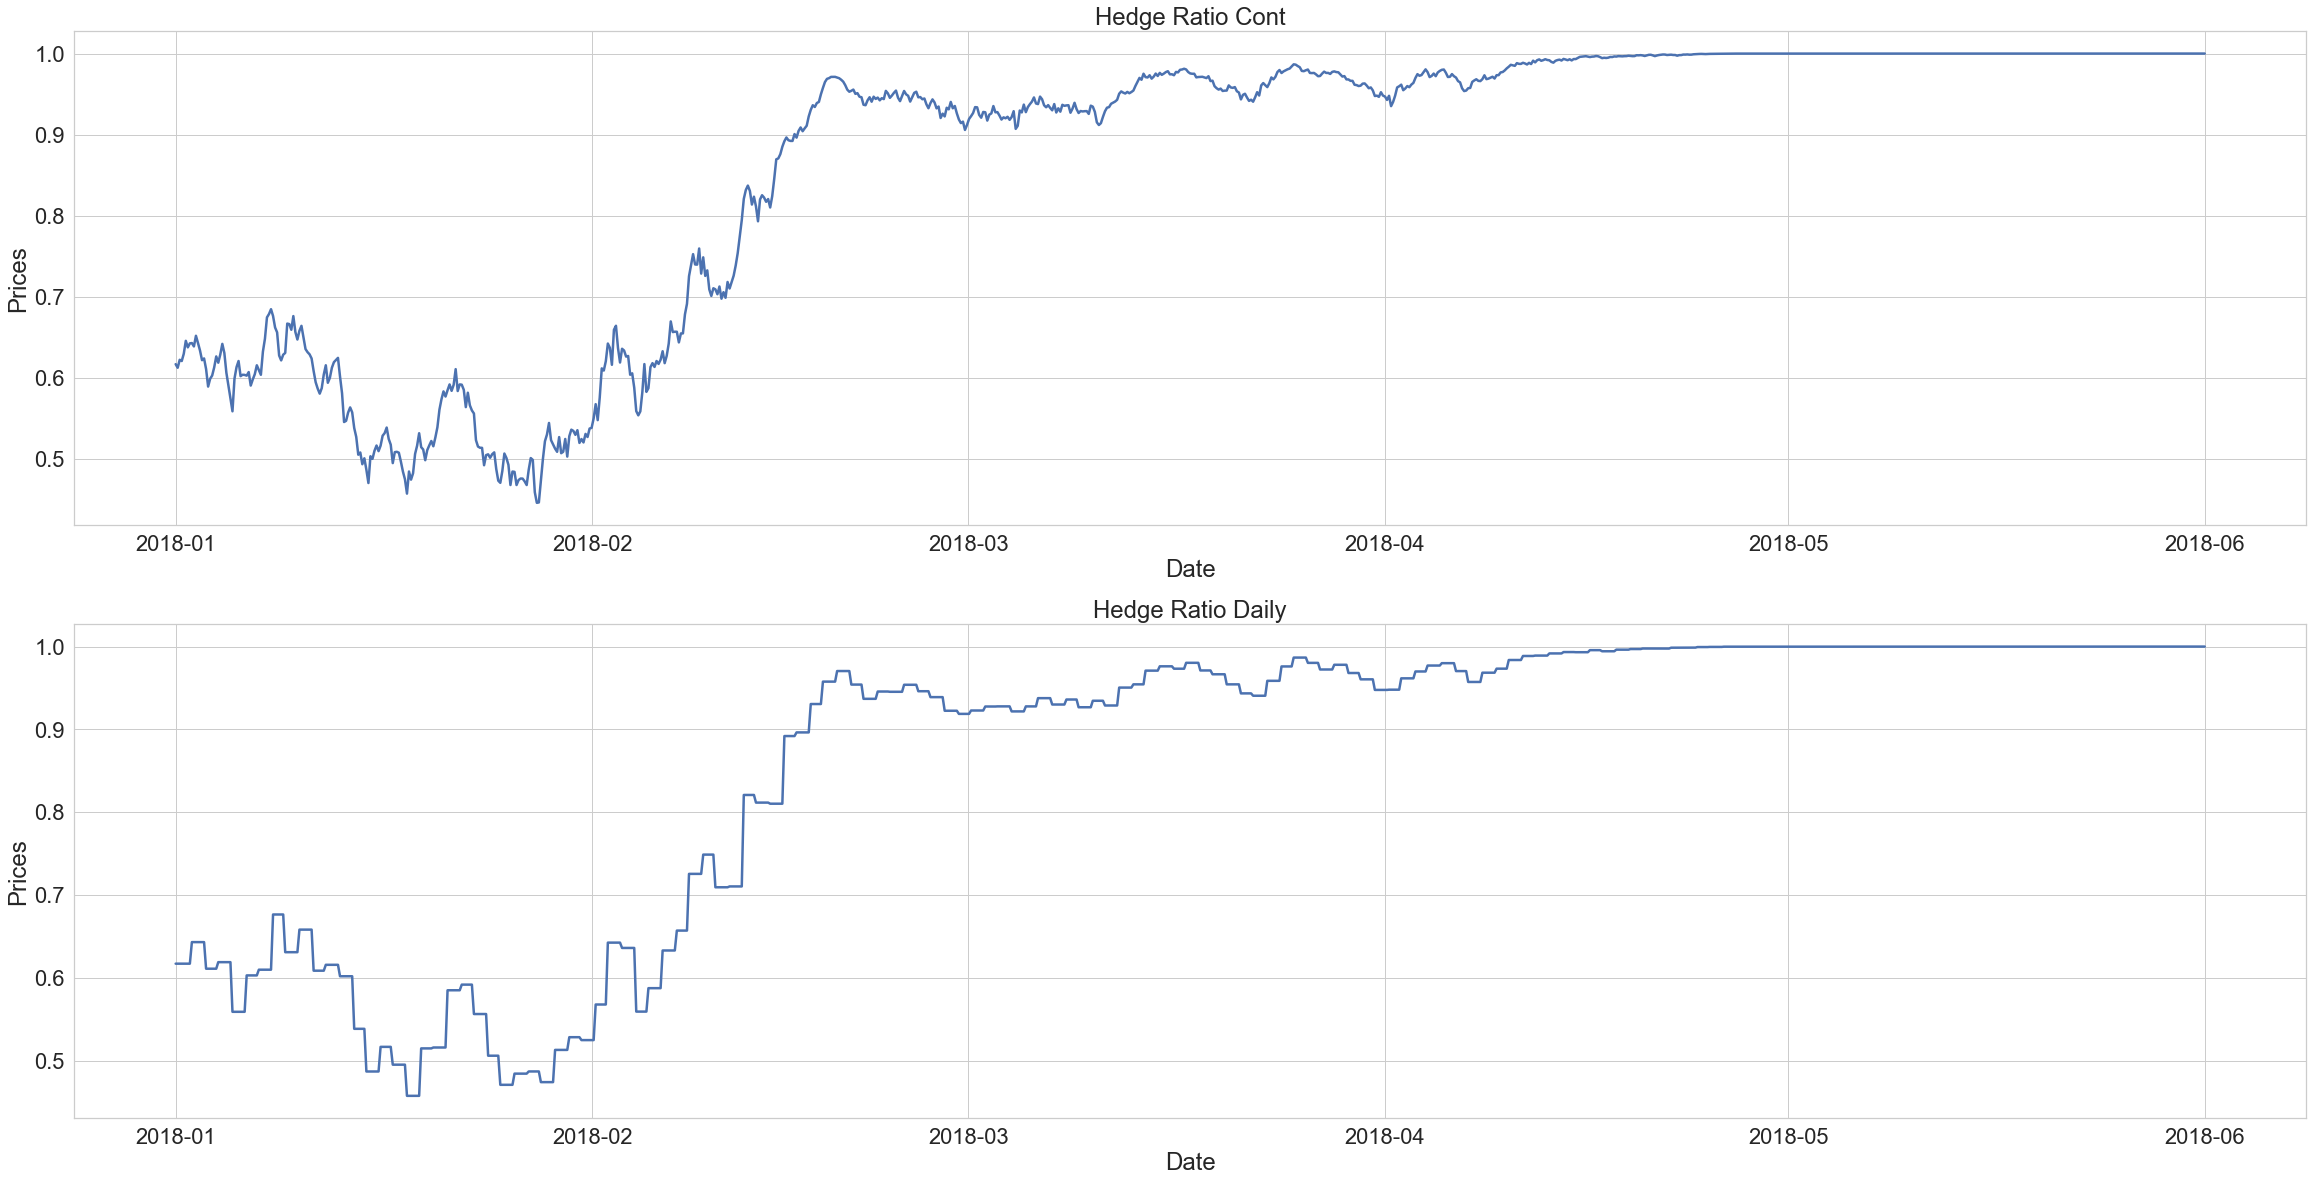

In [925]:
plt.figure(figsize=(40,20))
plt.subplot(2, 1, 1)
ax = sns.lineplot(data=opt_price["deltas"], palette="bright", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Prices', title="Hedge Ratio Cont")
plt.subplot(2, 1, 2)
ax = sns.lineplot(data=opt_price["delta_daily"], palette="bright", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Prices', title="Hedge Ratio Daily")

[Text(0, 0.5, 'Errors'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Hedging Errors')]

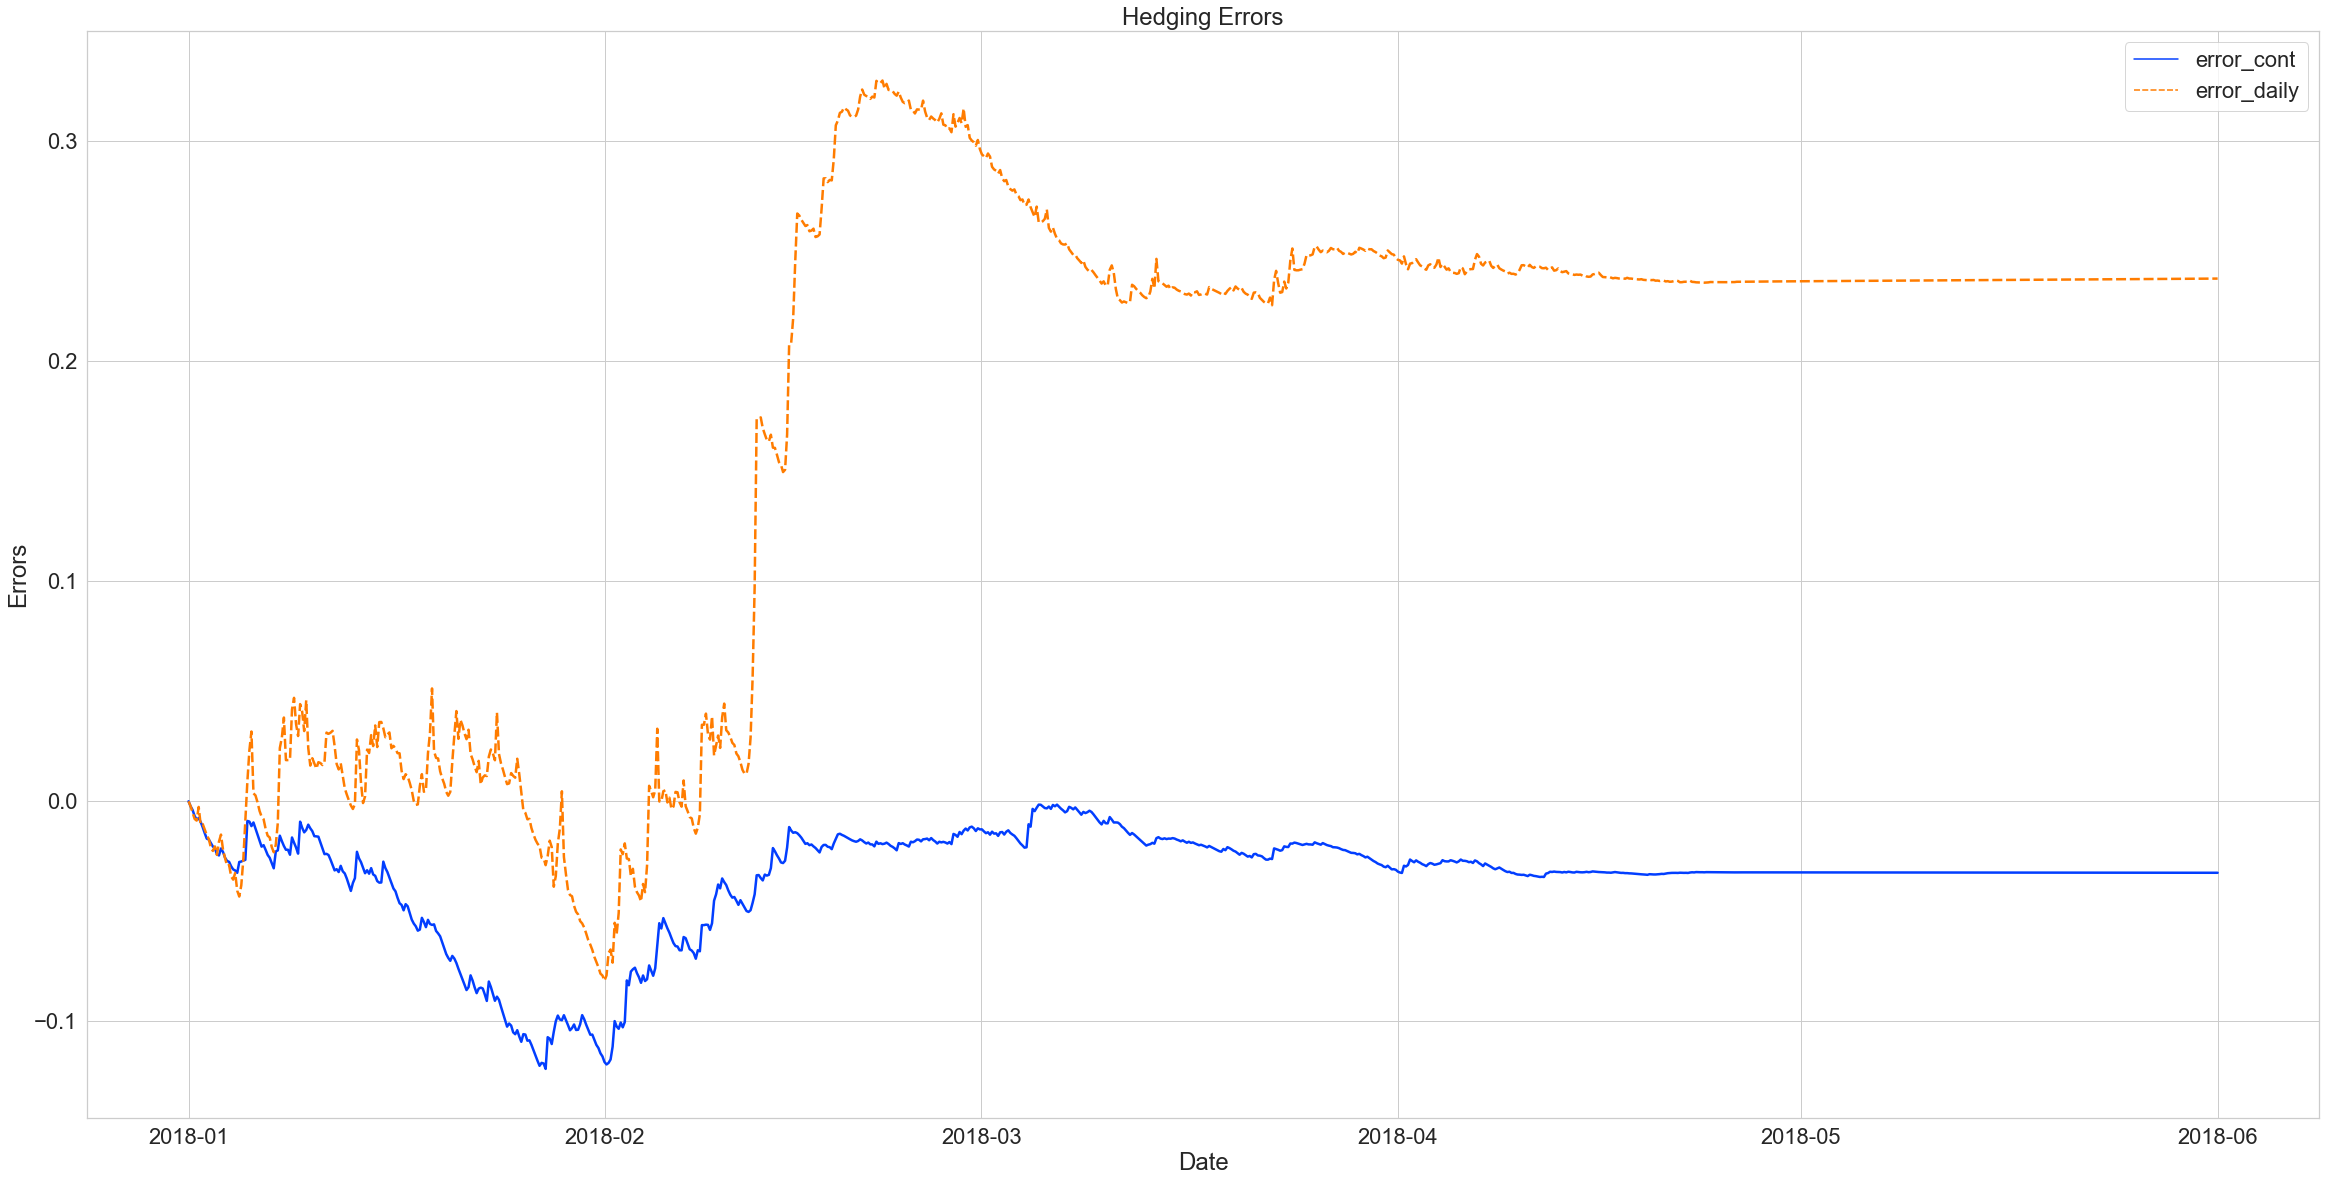

In [889]:
plt.figure(figsize=(40,20))
ax = sns.lineplot(data=opt_price[["error_cont", "error_daily"]], palette="bright", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Errors', title="Hedging Errors")

[Text(0, 0.5, 'Prices'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Cont. Hedging,  Total Hedging Error:34.955')]

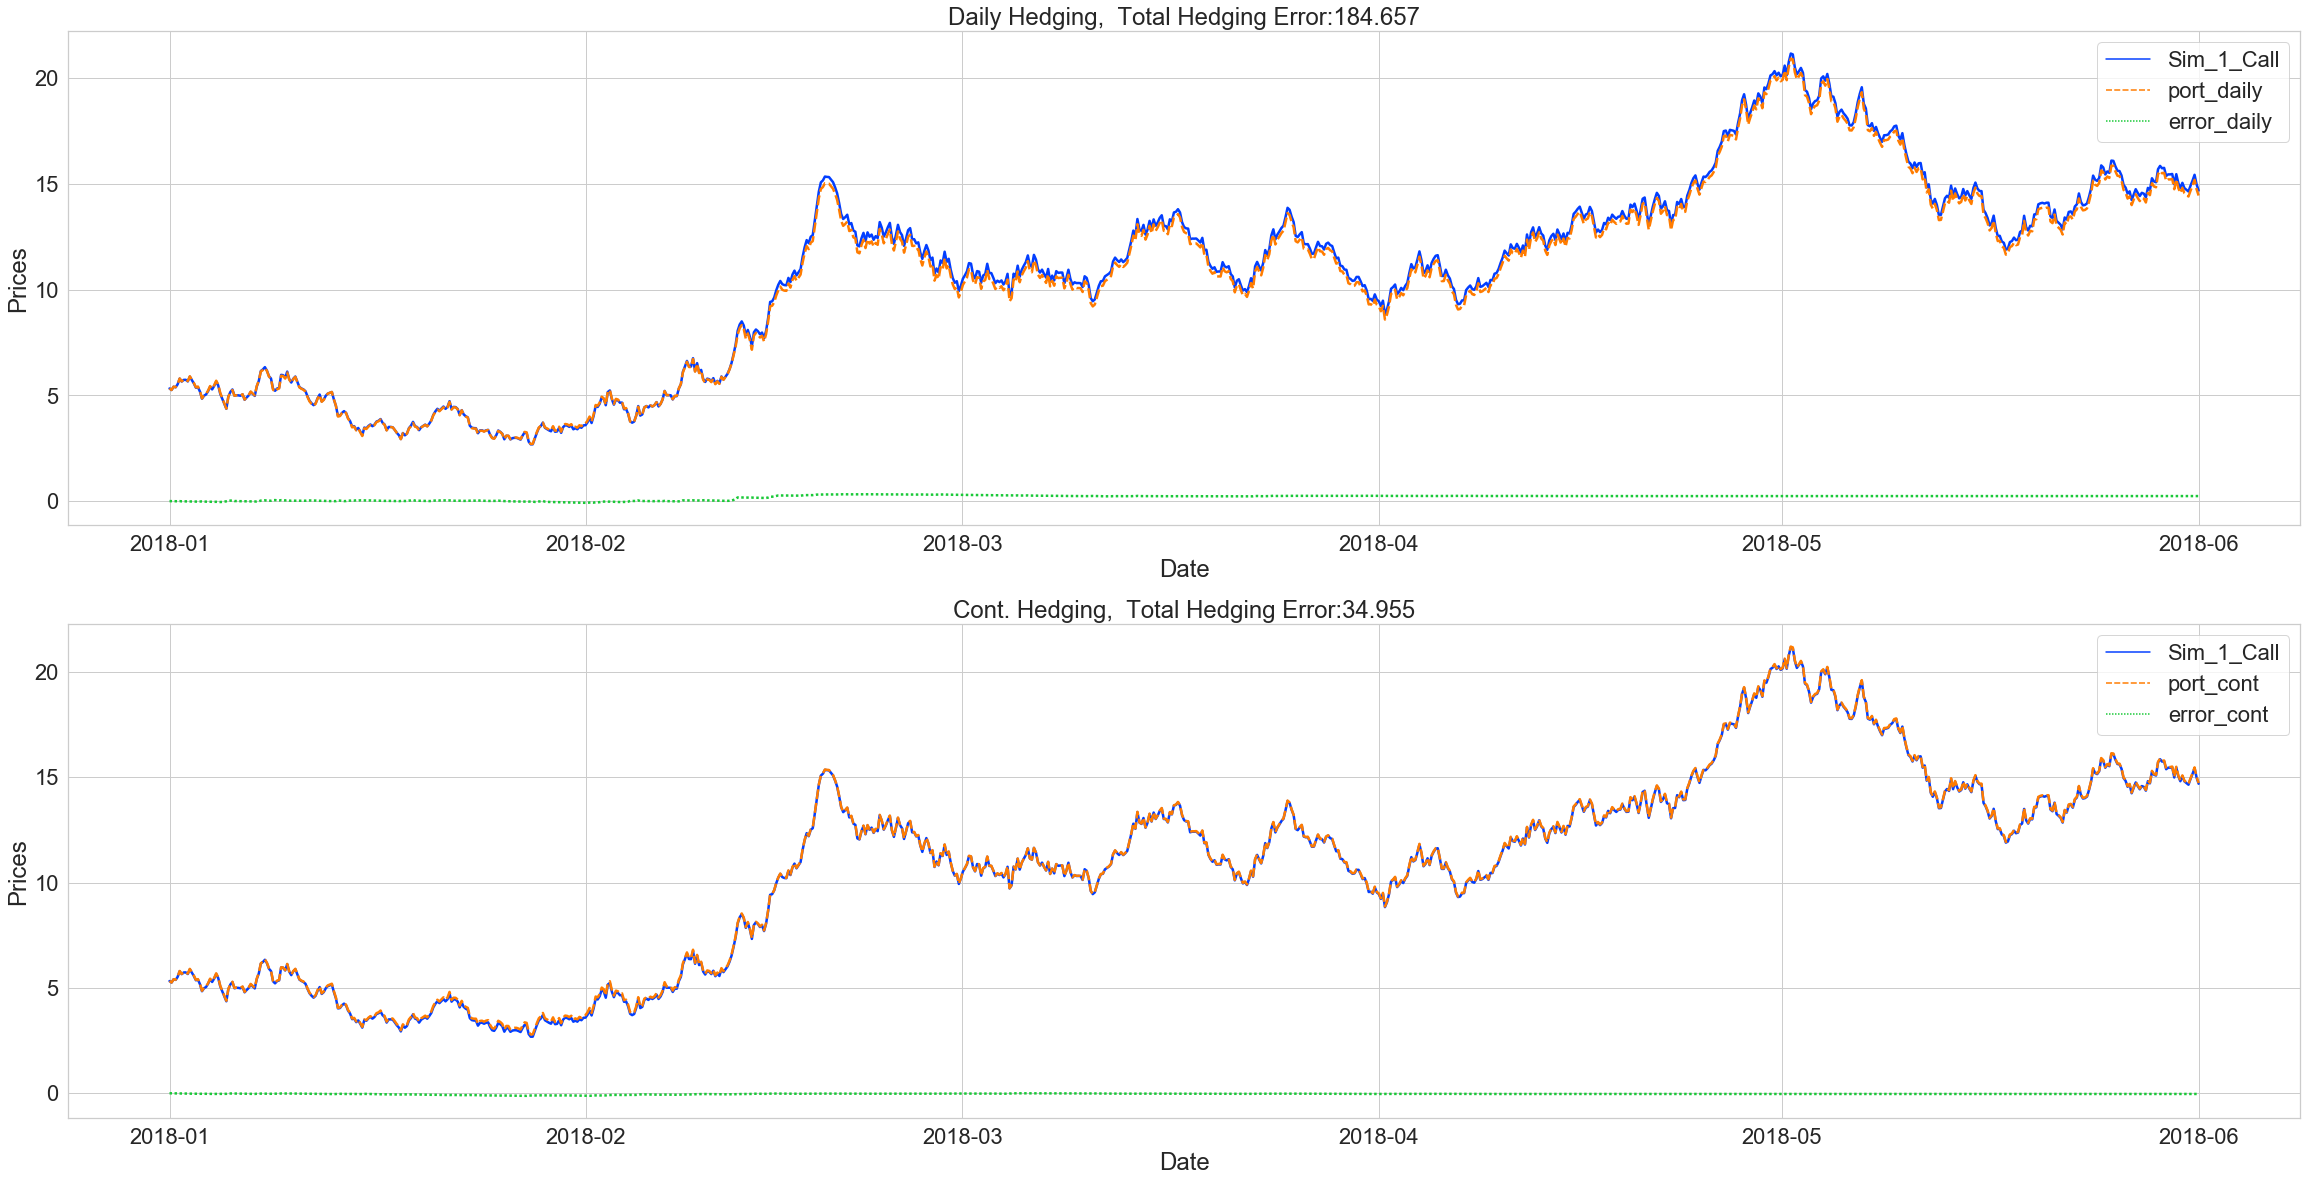

In [890]:
plt.figure(figsize=(40,20))
plt.subplot(2, 1, 1)
ax = sns.lineplot(data=opt_price[["Sim_1_Call", "port_daily", "error_daily"]], palette="bright", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Prices', title=f'Daily Hedging,  Total Hedging Error:{round(sum(np.abs(opt_price["error_daily"])), 3)}')
plt.subplot(2, 1, 2)
ax = sns.lineplot(data=opt_price[["Sim_1_Call", "port_cont", "error_cont"]], palette="bright", linewidth=2.5)
ax.set(xlabel='Date', ylabel='Prices', title=f'Cont. Hedging,  Total Hedging Error:{round(sum(np.abs(opt_price["error_cont"])), 3)}')

# Recovering Implied Volatility with Newton's Method

***Data obtained from a Case study, called Ito's Dilemma***

In [934]:
ito_data = pd.read_excel("/Users/guneykan/Desktop/ito_call_data.xlsx")

In [1079]:
def const_d1(s, k, r, t, vol):
    nomin = np.log(s/k) + (r + 0.5*(vol**2))*t
    denom = np.sqrt(t)*vol
    return(nomin/denom)
    

        
def call_const(k, r, t, s, vol):
    d1_ = (np.log(s/k) + (r + 0.5*(vol**2))*t)/(np.sqrt(t)*vol)
    d2_ = (np.log(s/k) + (r - 0.5*(vol**2))*t)/(np.sqrt(t)*vol)
    return(s*scipy.stats.norm.cdf(d1_) - k*np.exp(-r*t)*scipy.stats.norm.cdf(d2_))

In [1175]:
def newton(s, k, r, t, c, epochs):
    m = s/(k*np.exp(-r*t))
    sigma_0 = 0.5
    curr_sigma = sigma_0
    best_diff = 10000000000
    for a in range(epochs):
        d1_ = const_d1(s, k, r, t, curr_sigma)
        c_bs = call_const(k, r, t, s, curr_sigma)
        f = c - c_bs
        f_der = s*scipy.stats.norm.pdf(d1_)*np.sqrt(t)
        if np.abs(f)<best_diff:
            new_sigma = curr_sigma + (f/f_der)
            curr_diff = c - call(k, r, t, s, new_sigma)
            best_diff = np.abs(f)
            curr_sigma = new_sigma
            print("İteration:", a, "Market - BS:", curr_diff)
        else:
            print("Early Stoppin!", "\n", 
                 "Model Price:", round(c_bs,2), "Market Price:", c)
            break
    return(curr_sigma)
        
    
    

In [1176]:
implied_vols = []
for a in range(len(ito_data)):
    t = ito_data.loc[a, "Maturity"]/365
    k = ito_data.loc[a, "Strike"]
    s = ito_data.loc[a, "Spot"]
    r = ito_data.loc[a, "r"]
    c = ito_data.loc[a, "c_prem"]
    
    implied_vols.append(newton(s, k, r, t, c, 100))
    print("---------------------------------------------")

İteration: 0 Market - BS: 0.00028844292757046475
İteration: 1 Market - BS: 9.813039270056834e-11
İteration: 2 Market - BS: 8.881784197001252e-16
İteration: 3 Market - BS: 8.881784197001252e-16
Early Stoppin! 
 Model Price: 2.7 Market Price: 2.7
---------------------------------------------
İteration: 0 Market - BS: 0.00029802441150783565
İteration: 1 Market - BS: 1.5042322942804276e-10
İteration: 2 Market - BS: -2.220446049250313e-15
İteration: 3 Market - BS: 4.884981308350689e-15
Early Stoppin! 
 Model Price: 3.9 Market Price: 3.9
---------------------------------------------
İteration: 0 Market - BS: 0.0015894133625016238
İteration: 1 Market - BS: 4.244212981063811e-09
İteration: 2 Market - BS: -8.881784197001252e-16
İteration: 3 Market - BS: 2.6645352591003757e-15
Early Stoppin! 
 Model Price: 4.8 Market Price: 4.8
---------------------------------------------
İteration: 0 Market - BS: -7.164555491812052e-05
İteration: 1 Market - BS: -2.3638335733267013e-10
İteration: 2 Market - BS:

In [1200]:
ito_data

,Maturity,Strike,Spot,r,c_prem,implied_vol,Firms
0,25,42.5,42.2700,0.0492,2.70,0.621639,Duke
1,60,42.5,42.2700,0.0485,3.90,0.564468,Duke
2,151,42.5,42.2700,0.0491,4.80,0.417447,Duke
3,25,45.0,42.2700,0.0492,1.25,0.509409,Duke
4,60,45.0,42.2700,0.0485,2.40,0.492843,Duke
5,151,45.0,42.2700,0.0491,3.30,0.375392,Duke
6,60,40.0,42.2700,0.0485,4.30,0.426039,Duke
7,151,40.0,42.2700,0.0491,5.30,0.340804,Duke
8,25,100.0,108.9000,0.0492,12.00,0.583263,IBM
9,60,100.0,108.9000,0.0485,14.10,0.498858,IBM


In [1177]:
ito_data["implied_vol"] = implied_vols

In [1178]:
ito_data["Firms"][ito_data.Spot == 42.27] = "Duke"
ito_data["Firms"][ito_data.Spot == 108.9] = "IBM"
ito_data["Firms"][ito_data.Spot == 55.1875] = "Microsoft"

/Users/guneykan/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/guneykan/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/guneykan/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

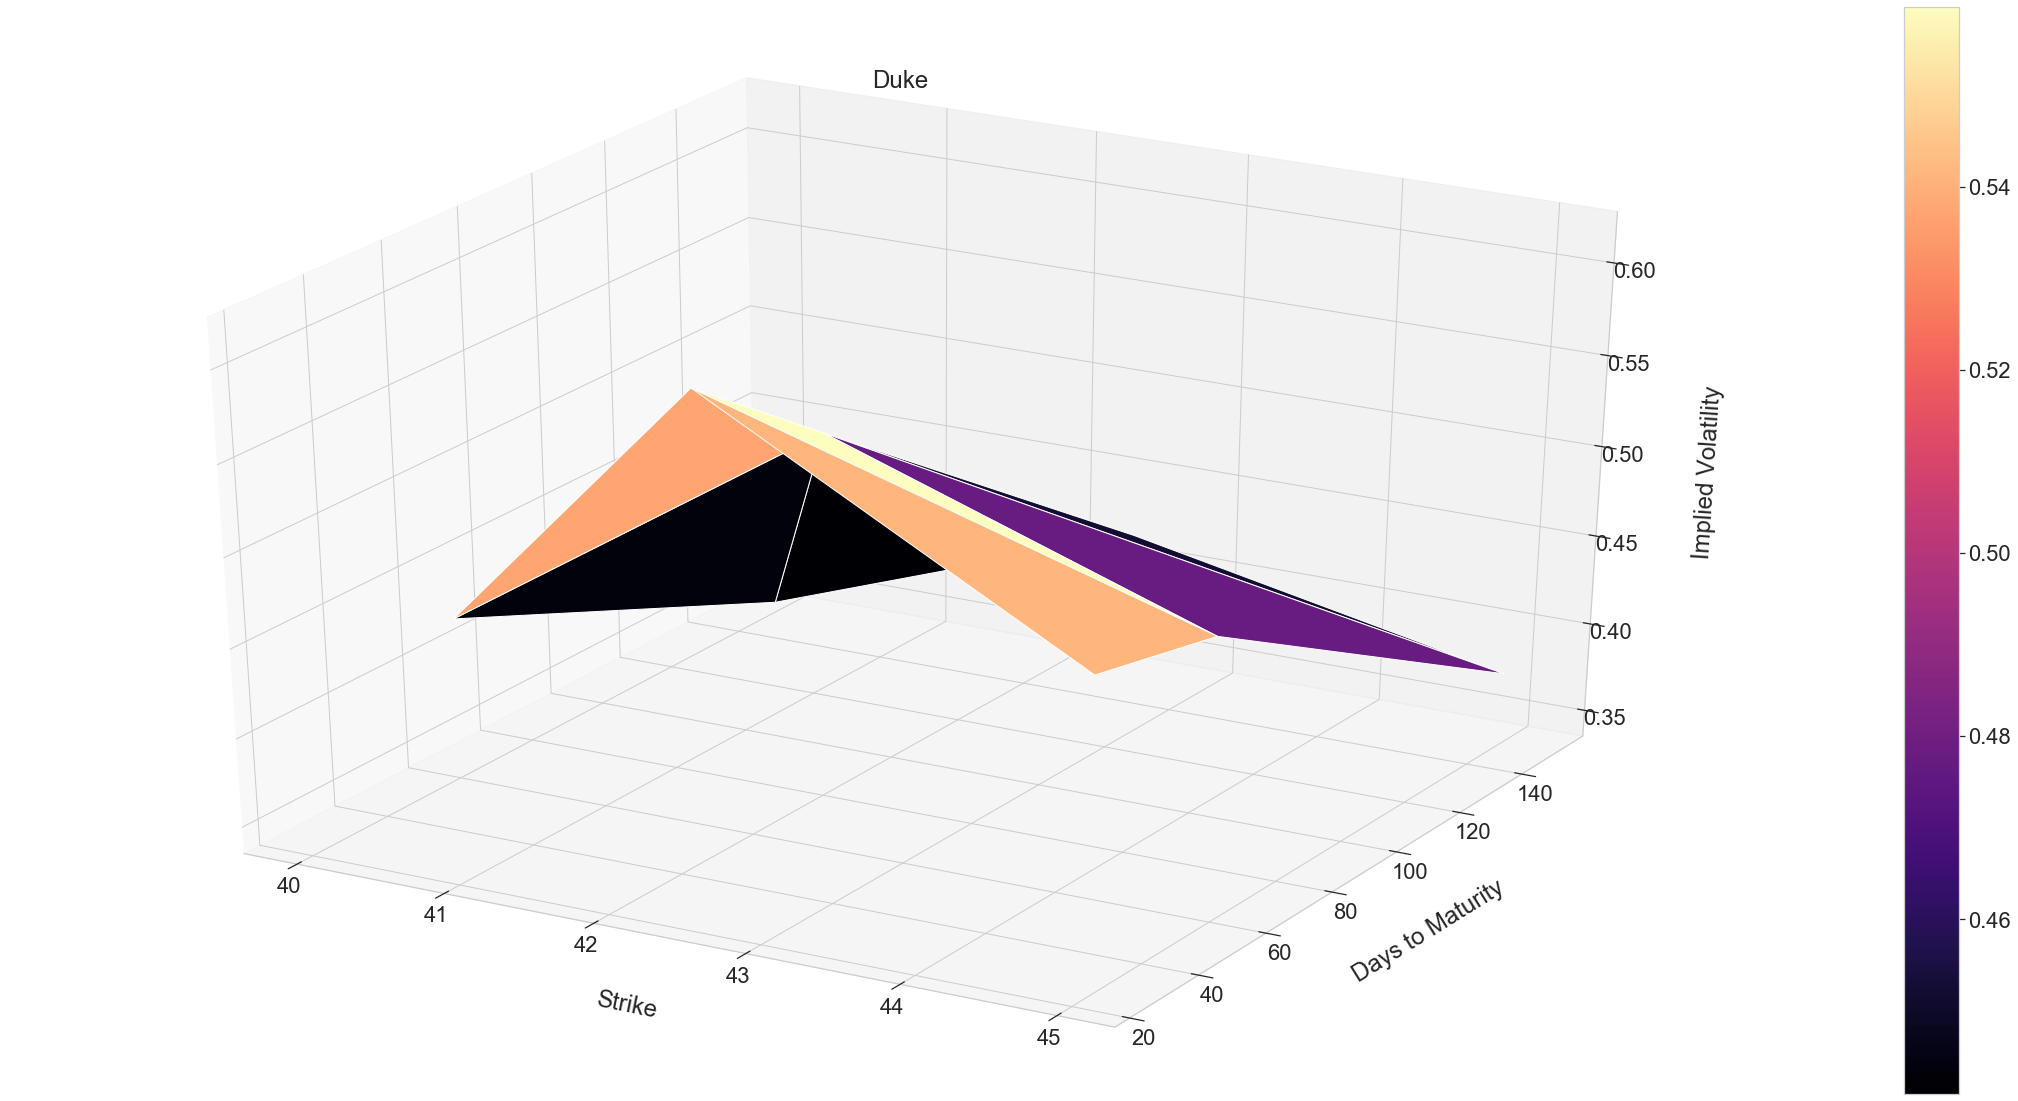

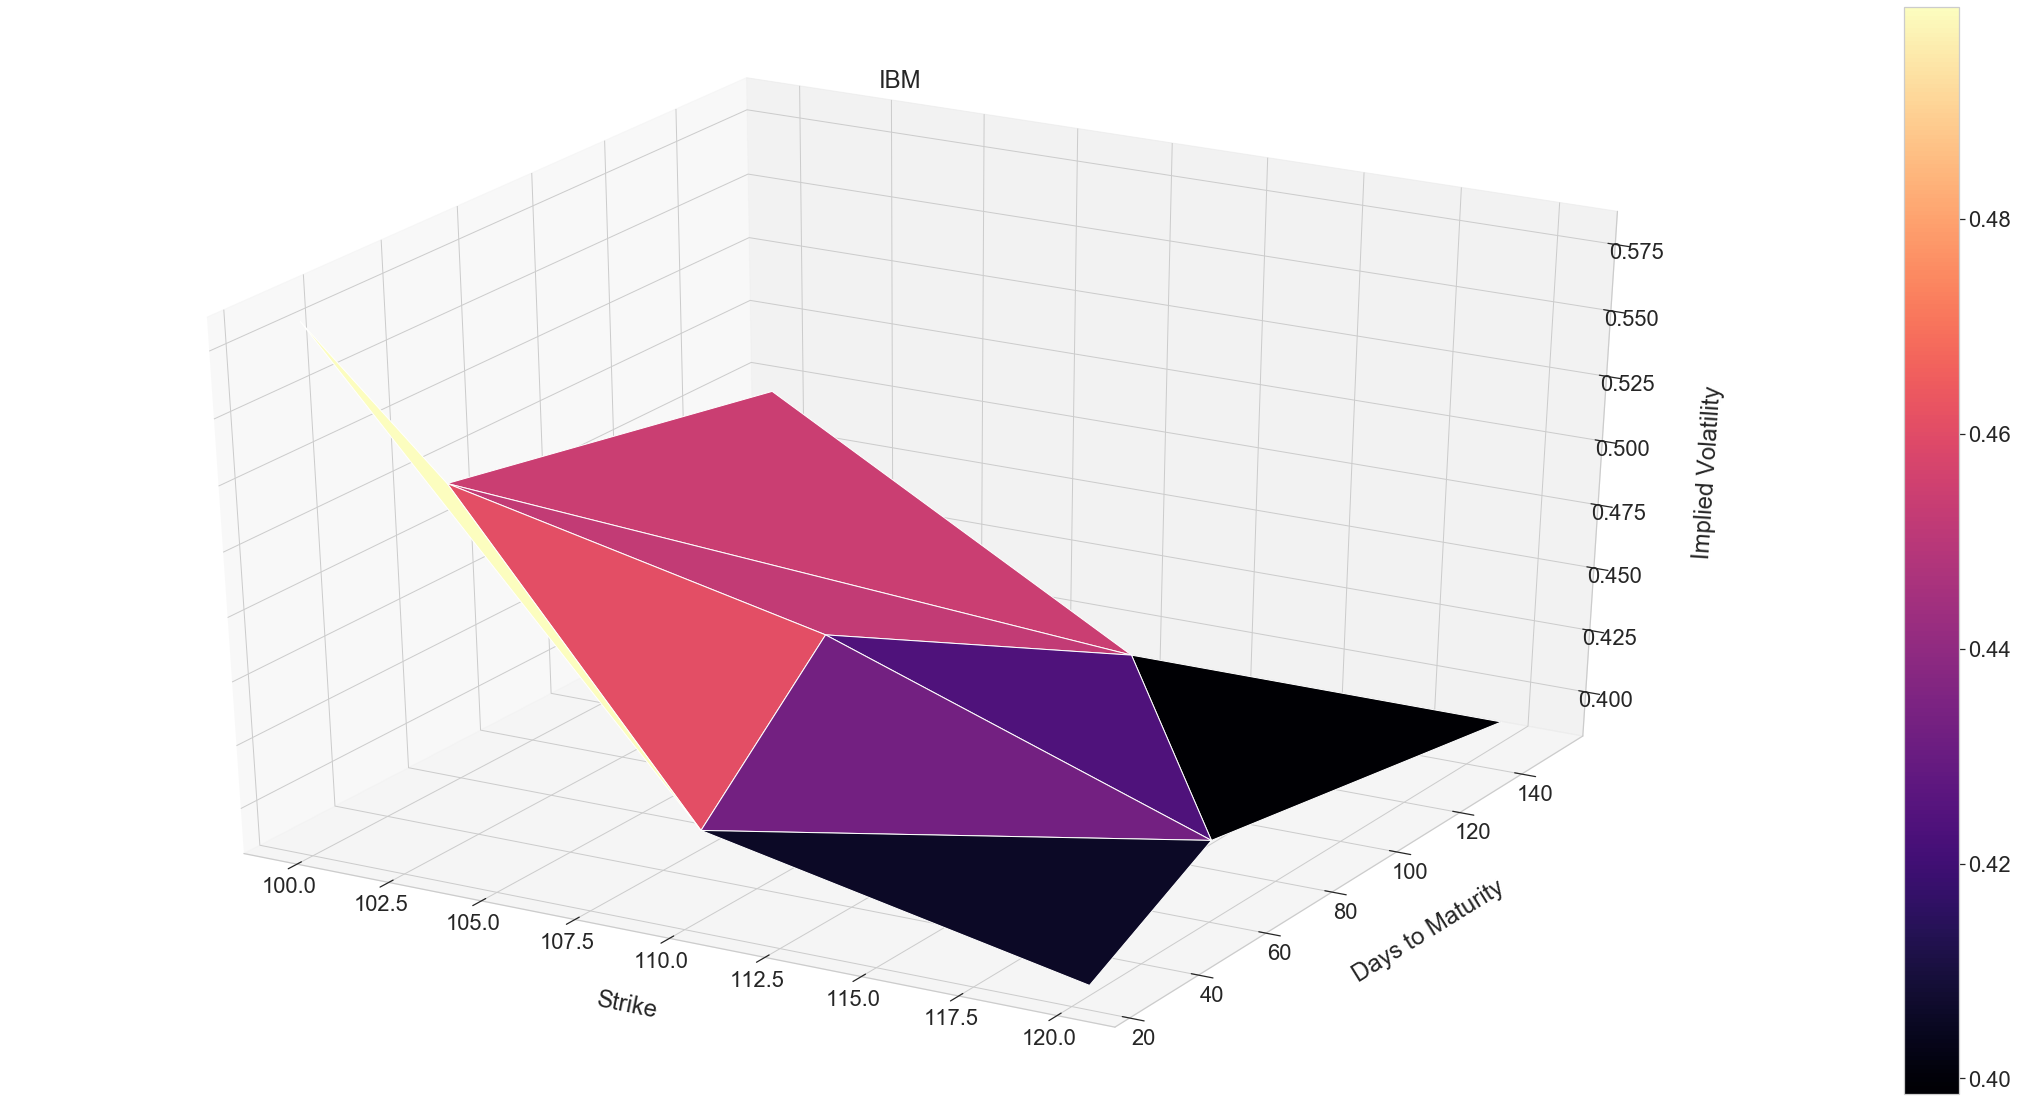

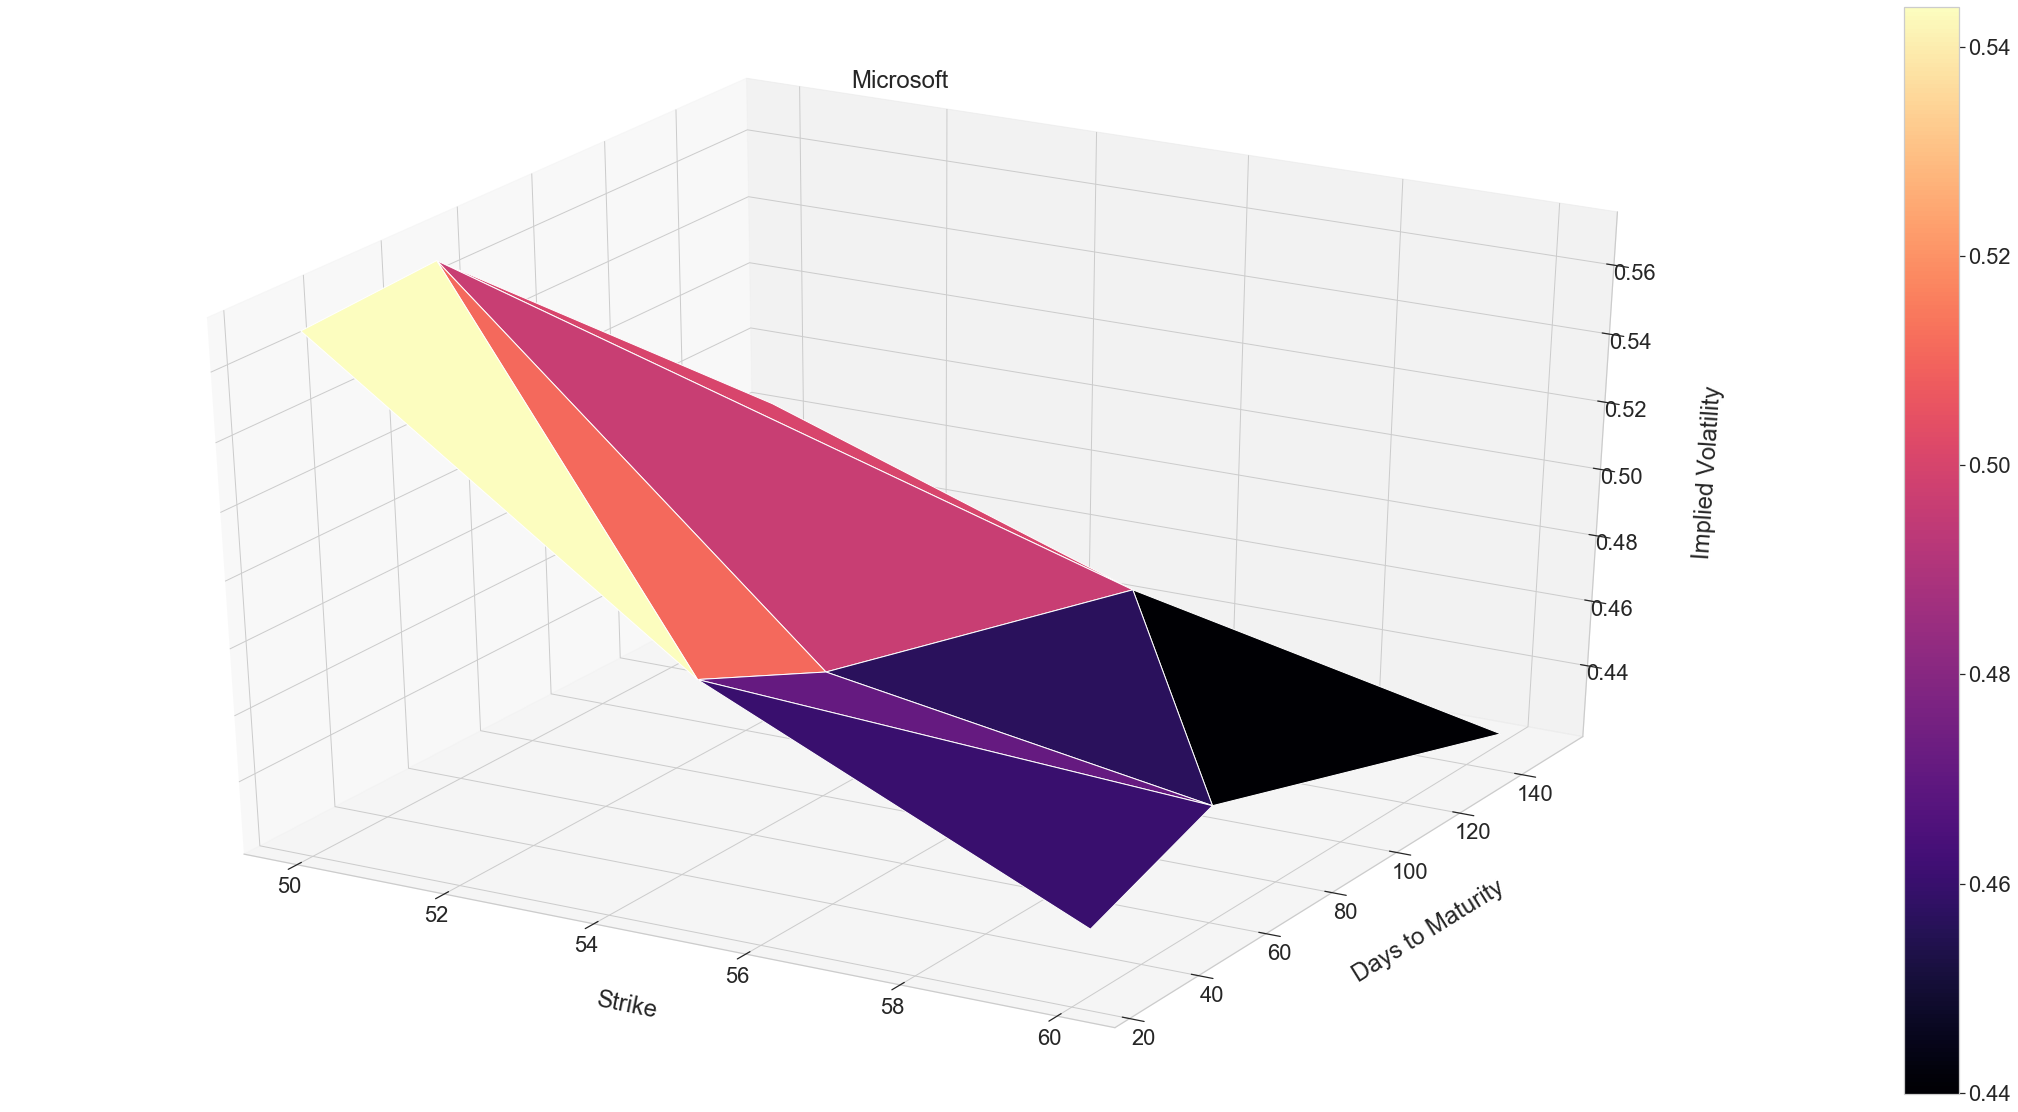

In [1181]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

for company in ito_data.Firms.unique():
    call_data = ito_data[(ito_data.Firms == company)]
    fig = plt.figure(figsize=(40,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(company)
    surf_1 = ax.plot_trisurf(call_data['Strike'], call_data['Maturity'], 
                    call_data['implied_vol'], label='call', cmap="magma")
    ax.set_xlabel('Strike', labelpad=40)
    ax.set_ylabel('Days to Maturity', labelpad=40)
    ax.set_zlabel('Implied Volatility', labelpad=40)
    surf_1._facecolors2d=surf_1._facecolors3d
    surf_1._edgecolors2d=surf_1._edgecolors3d
    fig.colorbar(surf_1)